# ProteusAI

In this notebook you are going to learn how we can use ProteusAI (PAI) to automate lots of stuff we did in the previous days. We are going to focus on computing representations, visualizing representations spaces, training models and model ensembles and evaluating the quality of the models.

We are also going to preview some other functions that can be used by PAI to handle other input data types like structures, how to visualize these, how to design novel sequences given a target structure and how to use protein language models (pLMs) to predict substitution probabilities.

## Loading tabular data and computing representations
first we have to import proteusAI, I always import it as pai so I don't always have to write the full name.

In [14]:
import proteusAI as pai
import matplotlib.pyplot as plt
%matplotlib inline

We are loading our 'source' data, the enzyme data using the 'Library'

In [27]:
enzyme_data = "Nitric_Oxide_Dioxygenase.csv"

lib = pai.Library(
    source=enzyme_data, 
    seqs_col="Sequence", 
    names_col="Description", 
    y_col="Data",
    y_type="num"
)

We can compute and plot BLOSUM62 representations in a single line

/Users/jonfu/miniforge3/envs/proteusAI/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


done plotting


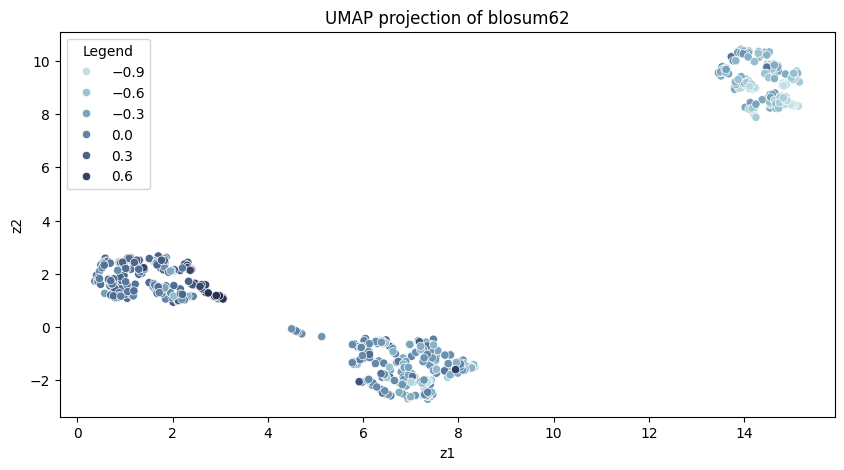

In [28]:
fig, ax, df = lib.plot("blosum62")
plt.show()

## Protein Language models in PAI

using protein language models in PAI is equally easy. We can simply use the function Library.compute() and specify the model we want to use. In this case we are going to use ESM-2, which is a state of the art protein language model. However, to speed the process up, we are going to use the 8 million parameter model (the smallest) which is not as powerful as the 650 million parameter model or the billion parameter models.

In [29]:
lib.compute("esm2_8M")

computing 0 proteins


Again, we can visualize the representation space, by calling the Library.plot() method

/Users/jonfu/miniforge3/envs/proteusAI/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


done plotting


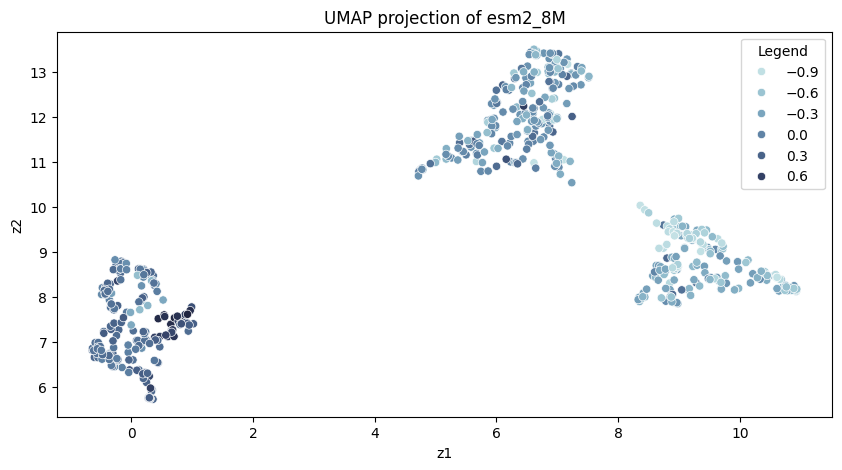

In [30]:
fig, ax, df = lib.plot("esm2_8M")
plt.show()

## Training machine learning models

To train machine learning models, similar to the first day, we can simply create a Model object that uses our Library as input and use the Model.train() method. The training output is captured in a dictionary that we can inspect, or we can use it as data source to create a Library object, this could be useful if we now for example wanted to plot the representations space using the predicted y_values.

In [34]:
model = pai.Model(
    library=lib, 
    model_type="rf", 
    x="blosum62",
    k_folds=5
)
out = model.train()

/Users/jonfu/github/ProteusAI/src/proteusAI/Model/model.py:144: FutureWarning: 'x' is deprecated and will be removed in a future version. Please use 'rep' instead.
  setattr(self, key, value)


Training completed:
val_r2:	0.6970369978911514
val_pearson:	PearsonRResult(statistic=0.8496351292969226, pvalue=3.4067736536039626e-17)


## Model statistics

Training the model will print some model statistics, but we can go deeper. While training the model, PAI automatically computes models statistics that can be used to inspect the models performance. It will compute R-squared values, pearson correlation coefficients, Kendall-Tau correlation coefficients, and perform a conformal prediction analysis to estimate how noisy your model + experiments are. Let's print some of those values and show a model diagnostics plot.

Validation R-squared:	 0.6970369978911514
Validation Pearson:	 PearsonRResult(statistic=0.8496351292969226, pvalue=3.4067736536039626e-17)
Validation Kendall-Tau:	 SignificanceResult(statistic=0.6382335148215365, pvalue=1.473880845138304e-12)
Model calibration:	 0.35068


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Predicted vs. True y-values'}, xlabel='y', ylabel='predicted y'>)

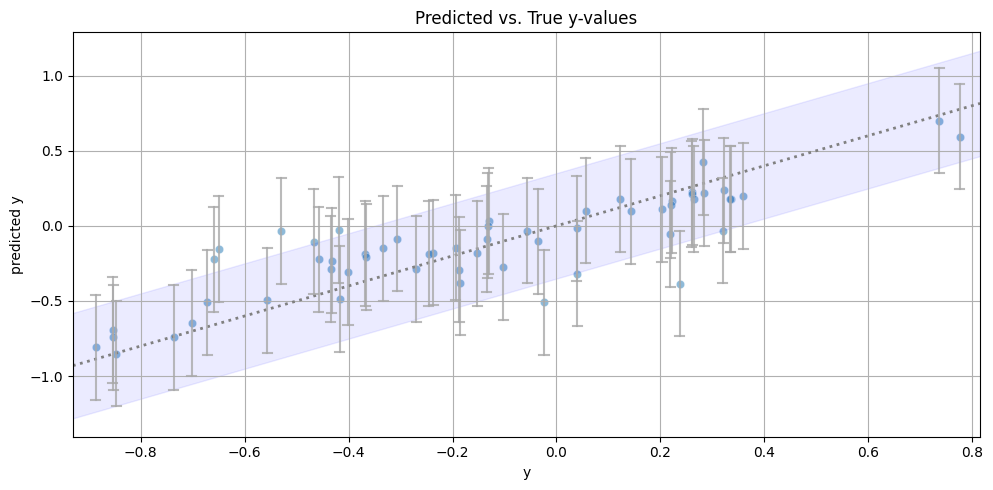

In [40]:
print("Validation R-squared:\t", model.val_r2)
print("Validation Pearson:\t", model.val_pearson)
print("Validation Kendall-Tau:\t", model.val_ken_tau)
print("Model calibration:\t", model.calibration)

model.true_vs_predicted(model.y_val, model.y_val_pred)

We see, that the Pearson correlation and the Kendall-Tau correlation coefficients are also equipped with pvalues to indicate statistical significance of these metrics.

**Task**: Plot the correlation of the true model error, versus the model uncertainty values with the residuals of the predicted versus the true validation y values. Do we observe that the model uncertainty correlates with the observed error?

Tip to access values:
- true validation y values = model.y_val
- predicted validation y values = model.y_val_pred

## Bayesian optimization in PAI

Once we have trained a model in PAI, we can use it to predict the activity of novel sequences, or immediately to predict the next experiments we could do. below we are using the upper confidence bound acquisition function, we are aiming to maximize our y-value, evaluate 10000 sequences per run and are quite exploitative.

In [42]:
out = model.search(
    acq_fn="ucb",
    optim_problem="max",
    max_eval=10000,
    explore=0.1
)

In [43]:
out

,name,sequence,y_true,y_predicted,y_sigma,acq_score
0,Y32G+F46S+L56S+V97G+P49P+R51R+I53L+L96E,MAPTLSEQTRQLVRASVPALQKHSVAISATMGRLLFERYPETRSLS...,None,0.779668,0.061511,0.871935
1,Y32G+F46S+L56S+V97G+P49P+R51R+I53L+V142C,MAPTLSEQTRQLVRASVPALQKHSVAISATMGRLLFERYPETRSLS...,None,0.779668,0.061511,0.871935
2,Y32G+F46S+L56S+V97G+P49P+R51R+I53L+R79W,MAPTLSEQTRQLVRASVPALQKHSVAISATMGRLLFERYPETRSLS...,None,0.779668,0.061511,0.871935
3,Y32G+F46S+L56S+V97G+P49P+R51H+I53L+H51R,MAPTLSEQTRQLVRASVPALQKHSVAISATMGRLLFERYPETRSLS...,None,0.779668,0.061511,0.871935
4,Y32G+F46S+L56S+V97G+P49P+R51R+I53G+G53L,MAPTLSEQTRQLVRASVPALQKHSVAISATMGRLLFERYPETRSLS...,None,0.779668,0.061511,0.871935
...,...,...,...,...,...,...
15751,Y32V+F46C+L56H+V97V+P49G+R51V+I53V+G49P,MAPTLSEQTRQLVRASVPALQKHSVAISATMVRLLFERYPETRSLC...,None,-0.897820,0.009452,-0.883642
15752,Y32V+F46C+L56H+V97V+P49Y+R51V+I53V+Y49P,MAPTLSEQTRQLVRASVPALQKHSVAISATMVRLLFERYPETRSLC...,None,-0.897820,0.009452,-0.883642
15753,Y32V+F46C+L56H+V97V+P49P+R51V+I53I+I53V,MAPTLSEQTRQLVRASVPALQKHSVAISATMVRLLFERYPETRSLC...,None,-0.897820,0.009452,-0.883642
15754,Y32V+F46C+L56H+V97V+P49P+R51V+I53F+F53V,MAPTLSEQTRQLVRASVPALQKHSVAISATMVRLLFERYPETRSLC...,None,-0.897820,0.009452,-0.883642


**Optional Task**: Come up with a method to do balance multiple objectives at once - This is going to be difficult, as a tip, read about what a Pareto-front is, remember that you can train multiple models on the same data.

# Protein Class

The protein class can be used to load protein sequences and protein structural information. this is particularily useful if we want to engineer a protein, but don't know where to make the first mutations, or if we want to engineer the protein based on its structure (for example to increase the thermostability). The protein class can also be used to perform data visualizations.

## Loading a protein structure and visualizing it

In [68]:
prot = pai.Protein(source="1zb6.pdb")

In [69]:
prot.view_struc()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

PAI also offers methods to extract interfaces, such as protein ligand interfaces. These interfaces can be important information when performing structure based design workflows.

In [77]:
interface = prot.get_contacts(target="ligand", dist=7)
highlight = {"A":interface}

prot.view_struc(
    highlight=highlight,
    #sticks=interface
)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Structure based design

In the following we are going to use an inverse folding algorithm (ESM-IF) to sample sequences conditioned on our input structure. It has been shown, that sequences sampled through inverse folding algorithms often show increased themostability and expression levels. In some cases, even properties like catalytic activity can be increased.

In [80]:
out = prot.esm_if(
    num_samples=10,
    target_chain="A",
    fixed=interface
)

/Users/jonfu/miniforge3/envs/proteusAI/lib/python3.8/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


Native sequence for chain ['A'] loaded from structure file:
MSEAADVERVYAAMEEAAGLLGVACARDKIYPLLSTFQDTLVEGGSVVVFSMASGRHSTELDFSISVPTSHGDPYATVVEKGLFPATGHPVDDLLADTQKHLPVSMFAIDGEVTGGFKKTYAFFPTDNMPGVAELSAIPSMPPAVAENAELFARYGLDKVQMTSMDYKKRQVNLYFSELSAQTLEAESVLALVRELGLHVPNELGLKFCKRSFSVYPTLNWETGKIDRLCFAVISNDPTLVPSSDEGDIEKFHNYATKAPYAYVGEKRTLVYGLTLSPKEEYYKLGAYYHITDVQRGLLKAFDSLED


In [81]:
out

{'df':             names  recovery  log_likelihood  \
 0   sampled_seq_1  0.371336       -2.331239   
 1   sampled_seq_2  0.374593       -2.291955   
 2   sampled_seq_3  0.381107       -2.366091   
 3   sampled_seq_4  0.351792       -2.305086   
 4   sampled_seq_5  0.374593       -2.357185   
 5   sampled_seq_6  0.416938       -2.251400   
 6   sampled_seq_7  0.384365       -2.336526   
 7   sampled_seq_8  0.358306       -2.296867   
 8   sampled_seq_9  0.355049       -2.385718   
 9  sampled_seq_10  0.387622       -2.301738   
 
                                             sequence  
 0  MPNDKLNEDLVKAIGADVGQVDARVSEPQHFEPLKVIEPDLELEFM...  
 1  PPDDHQTQKVIALCVRLLSLLGSDFNTERLDAPLYIFHETLAPGEF...  
 2  MPNEDAELEMIADIQENAGVLAYSVDETKMTPPMESFNPTVSRGLV...  
 3  MLNPTGTNDVIALVQENAGLVGQQIDESDALAPLEVFQSELNKECL...  
 4  GDKPDSEAYLLHAFAKNCGLRGLSVIASLYVPPLSLFSPSLTEVNF...  
 5  ADQQEAHEEFLGLFCHQAGLTGEPSDDAKTLAPLEFFEDTLEEGKT...  
 6  MLLQDAVHRFVKFFARAAGARGRHVDEPKTLEFFRVFQAALDEHRS...  
 7  MENEDLVANFVA